## SAR images denoise with the trained model. 
Here the images are pre-processed with SNAP software: 
orbit file corrected, radiometrically calibrated and pixel amplitude adjusted to 0-255
In previous notebook sar_denoise_cal_db.ipynb I noticed artifacts after the denoise. The images had square looking artifacts that most likely were caused due to 0 tapering and padding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
from diffusers import DDPMScheduler, UNet2DModel
from sar_denoise.DDPMSpecklePipeline import DDPMSpecklePipeline
from datasets import load_dataset
from tqdm import tqdm
from pathlib import Path
from einops import rearrange
from scipy import signal
import math

In [2]:
# SAR files after orbital correction and radiometrically callibrated, db scaled to 0-255
dir_out_512_cal = Path('/data/sar/sar_data/sar_tiles_png_cal_512/')
sar_orb_cal = Path('/data/sar/sar_data/SAR_Orb_Cal')

# These are orbit corrected, calibrated and db scaled to 0-255 range files pre-processed with SNAP:
f1_db = 'f0658ae_f6f2_GRDH_Orb_Cal_Sigma0_VH_db.tif'
f1_vh_db = 'f0658ae_f6f2_GRDH_Orb_Cal_Sigma0_VH_db.png'
f1_vv_db = 'f0658ae_f6f2_GRDH_Orb_Cal_Sigma0_VV_db.png'

full_dataset = load_dataset(os.path.join(dir_out_512_cal))

Resolving data files:   0%|          | 0/1518 [00:00<?, ?it/s]

In [3]:
unet = UNet2DModel.from_pretrained("/data/diffden/exp_speckle_1_output/unet")
# use torch.compile on this

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

# TODO can just load pipeline instead of loading unet?
pipeline = DDPMSpecklePipeline(
    unet=unet,
    scheduler=noise_scheduler,
).to("cuda")

device = pipeline.device

In [4]:
# Preprocessing the datasets and DataLoaders creation.

def xf(image):
    # l_image = Image.fromarray(image).convert("L")
    # image will have values in range [0-255]
    tensor_image = torch.Tensor(np.array(image)).unsqueeze(0)
    # normalize to [-0.5, 0.5]
    return (tensor_image - 127.5) / 255.
    

def transform_images(examples):
    # images = [augmentations(image.convert("L")) for image in examples["image"]] # Images are already 'L' mode
    images = [xf(image) for image in examples["image"]]
    return {"input": images}

full_dataset.set_transform(transform_images)

In [5]:
# plt.imshow(full_dataset['train'][33]['input'])
# full_dataset['train'][33]['input'].unsqueeze(0).shape
image_indices = (np.r_[:16] * 17 + 31).astype(int).tolist()
dataset = torch.utils.data.Subset(full_dataset["train"], image_indices)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

In [6]:
def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def plot_image_batch(images):
   # note: it might be better to normalize each image in the batch individually
   images_np = (normalize_image(images) * 255).float().round().cpu().squeeze(1).numpy().astype(np.uint8) 

   fig, axs = plt.subplots(4, 4, figsize=(20, 20))
   for i, ax in enumerate(axs.flat):
       ax.imshow(images_np[i], cmap="gray")
       ax.axis("off")

In [7]:
val_batch = next(iter(dataloader))
val_images = val_batch["input"].to(device)

print(val_images.shape)
# plot_image_batch(val_images)

torch.Size([16, 1, 512, 512])


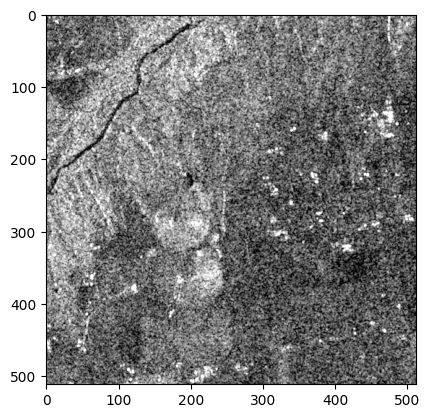

In [8]:
img = val_images[2]
im = (normalize_image(img) * 255).float().round().cpu().squeeze(1).numpy().astype(np.uint8).squeeze()
plt.imshow(im, cmap='gray')

## Designing padding window to avoid edge artifacts:

In [123]:
# ## Linear padding on all 4 sides, 32x32 mid section, 16 pixel linear pading on sides:

# window_down = 1 - np.linspace(0, 1, 16, dtype = np.float32)
# window_mid = np.linspace(1, 1, 32).astype(np.float32)*np.ones((32,32),dtype=np.float32)
# window = torch.tensor(window_mid)           #.unsqueeze(0).unsqueeze(0).to("cuda")

# for i in range(len(window_down)):
#     window = F.pad(window, mode = "constant", pad=(1, 1, 1, 1), value = window_down[i])

# padding = torch.tensor(window).unsqueeze(0).unsqueeze(0).to("cuda")

# # heatmap of the padding window:
# plt.imshow(window, cmap = 'viridis')

In [11]:
## Tukey window:
##  checking if Tukey window sums up to 1 (it does not)
window = signal.windows.tukey(M=32, alpha=1, sym=True)

w1 = window[0:16]
w2 = window[16:32]
w_sum = 1 - (w1+w2)
print(w_sum, np.max(w_sum)) # values don't sum up to 1!

[0.00256534 0.01269534 0.0223056  0.03100266 0.03843047 0.04428493
 0.04832636 0.0503893  0.0503893  0.04832636 0.04428493 0.03843047
 0.03100266 0.0223056  0.01269534 0.00256534] 0.05038930433293198


## Custom building Tukey window that sums up to 1:

all corners sum up to 1. min:  1.0  max:  1.0


/tmp/ipykernel_11342/1579922149.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padding = torch.tensor(window).unsqueeze(0).unsqueeze(0).to("cuda")


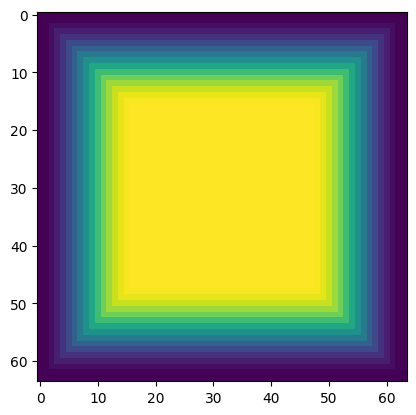

In [17]:
r = 32
x = np.linspace(1, r , r, int)  # x range from 1 to 32

window_tukey = []

for i in range(len(x)):
    w = (1 + math.cos(2*math.pi*(x[i] - r/2)/r))/2
    window_tukey.append(w)

# QC that two sides sum up to 1:
w1 = window_tukey[0:16]
w2 = window_tukey[16:32]
w_sum = []
for i, j in zip(w1, w2):
    w_sum.append(i+j)

print("all corners sum up to 1. min: ", np.min(w_sum), " max: ", np.max(w_sum)) # all corners sum up to 1

window_mid = np.linspace(1, 1, 32).astype(np.float32)*np.ones((32,32),dtype=np.float32)
N = 16
window = torch.tensor(window_mid)

for i in range(16, 32):
    window = F.pad(window, mode = "constant", pad=(1, 1, 1, 1), value = window_tukey[i])

padding = torch.tensor(window).unsqueeze(0).unsqueeze(0).to("cuda")

# heatmap of the padding window:
plt.imshow(window, cmap = 'viridis')

In [18]:
# print(val_images.shape)

val_images_uf64 = torch.nn.functional.unfold(val_images, kernel_size = 64, stride=16)
print(val_images_uf64.shape)
val_images_uf64 = rearrange(val_images_uf64, "b (c h w) p -> p b c h w", c=1, h=64, w=64) * padding
print(val_images_uf64.shape, val_images.shape)

torch.Size([16, 4096, 841])
torch.Size([841, 16, 1, 64, 64]) torch.Size([16, 1, 512, 512])


## SAR images despeckling with 100 inference steps:

In [277]:
# this runs for a very long time.

generator = torch.Generator(device=pipeline.device).manual_seed(0)

denoised_images_uf64_100steps = torch.zeros_like(val_images_uf64) 

for i in tqdm(range(val_images_uf64.shape[0]), colour="blue", desc="patch"):
    pipeline.progress_bar = lambda _: _
    denoised_images_uf64_100steps[i] = pipeline(val_images_uf64[i], generator=generator, num_inference_steps=100, return_tensor=True)


patch: 100%|██████████| 841/841 [25:42<00:00,  1.83s/it]


In [21]:
denoise_SAR_cal_db_p_tukey3_100steps = torch.nn.functional.fold(rearrange(denoised_images_uf64_100steps, "p b c h w -> b (c h w) p"), output_size=512, kernel_size=64, stride=16)

NameError: name 'denoised_images_uf64_100steps' is not defined

In [22]:
# torch.save(denoise_SAR_cal_db_p_tukey3_100steps, '/data/sar/denoise_SAR_cal_db_p_tukey3_100steps')
denoise_SAR_cal_db_p_tukey3_100steps = torch.load('/data/sar/denoise_SAR_cal_db_p_tukey3_100steps')

# denoise_SAR_cal_db_p1_100steps padding horizontally only stride = 16 (16, 32, 16)

In [23]:
# Despeckled images calibrated and db corrected, no padding (edge artifacts):
denoise_SAR_cal_db_100steps = torch.load('/data/sar/denoise_SAR_cal_db_100steps')

In [24]:
#plot_image_batch(denoise_SAR_cal_db_p1_100steps)

(-0.5, 383.5, 383.5, -0.5)

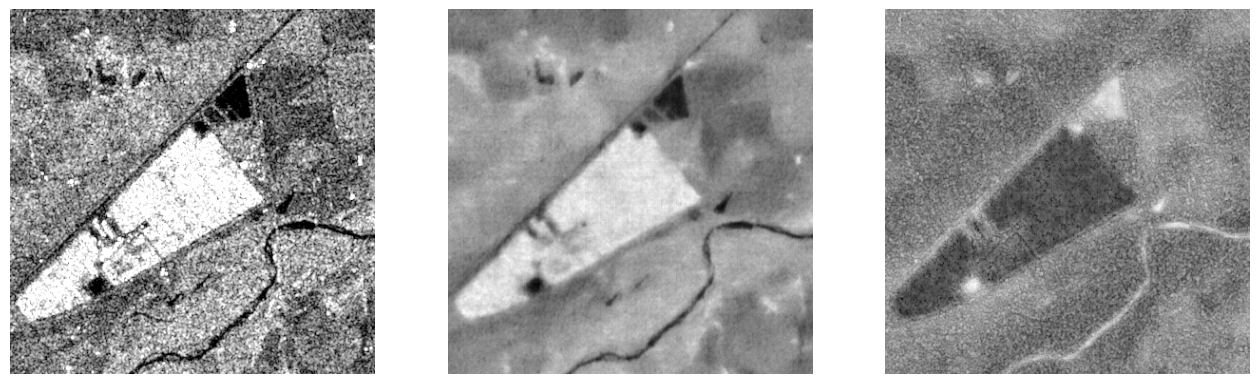

In [25]:

valid_slice = slice(64, 512-64)
valid_region = tuple(valid_slice for _ in range(2))

def f(image):
    image = image.cpu().squeeze(0)
    image = image[valid_region]
    image = normalize_image(image)
    #image = normalize_image(np.log(image + 1e-6))
    return image

indices = list(range(len(val_images)))

# # plot pairs of images next to each other
# fig, ax = plt.subplots(len(indices), 3, figsize=(8, len(indices)*3))
# for i, idx in enumerate(indices):
#     ax[i, 0].imshow(f(val_images[idx]), cmap="gray")
#     ax[i, 0].axis("off")
#     ax[i, 1].imshow(f(denoise_SAR_cal_db_p_tukey3_100steps[idx]), cmap="gray")
#     ax[i, 1].axis("off")
#     diff = f(val_images[idx]-denoise_SAR_cal_db_p_tukey3_100steps[idx])
#     ax[i, 2].imshow(diff, cmap="gray")
#     ax[i, 2].axis("off")
#     fig.tight_layout()


fig, ax = plt.subplots(1, 3, figsize=(16, 6))
idx = 10
ax[0].imshow(f(val_images[idx]), cmap="gray")
ax[0].axis("off")
ax[1].imshow(f(denoise_SAR_cal_db_p_tukey3_100steps[idx]), cmap="gray")
ax[1].axis("off")
diff = (val_images[idx]-denoise_SAR_cal_db_p_tukey3_100steps[idx]).cpu().squeeze(0)[valid_region]
ax[2].imshow(diff, cmap="gray")
ax[2].axis("off")

## Comparison of images between no padding and padded with tukey edges:

(-0.5, 383.5, 383.5, -0.5)

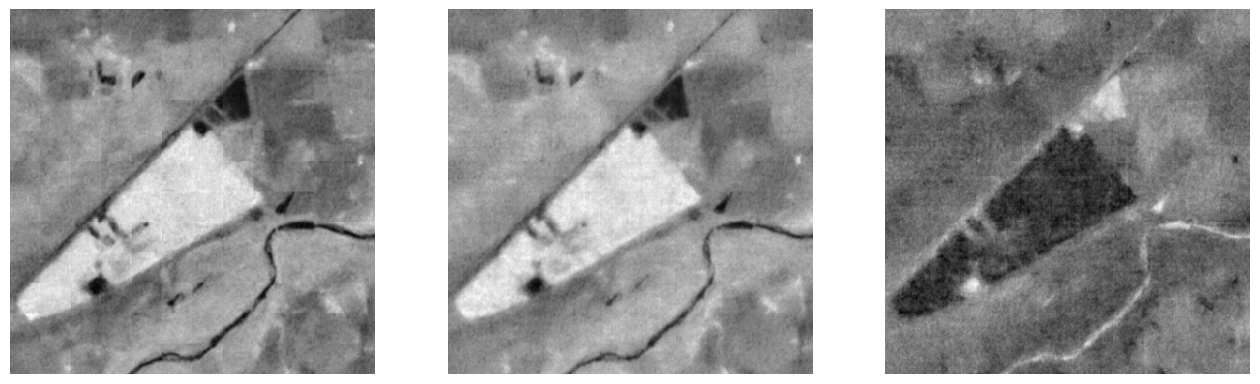

In [26]:
valid_slice = slice(64, 512-64)
valid_region = tuple(valid_slice for _ in range(2))

def f(image):
    image = image.cpu().squeeze(0)
    image = image[valid_region]
    image = normalize_image(image)
    #image = normalize_image(np.log(image + 1e-6))
    return image

indices = list(range(len(val_images)))

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
idx = 10
ax[0].imshow(f(denoise_SAR_cal_db_100steps[idx]), cmap="gray")
ax[0].axis("off")
ax[1].imshow(f(denoise_SAR_cal_db_p_tukey3_100steps[idx]), cmap="gray")
ax[1].axis("off")
diff = f(denoise_SAR_cal_db_100steps[idx]-denoise_SAR_cal_db_p_tukey3_100steps[idx])#.cpu().squeeze(0)[valid_region]
ax[2].imshow(diff, cmap="gray")
ax[2].axis("off")

# plot pairs of images next to each other
# fig, ax = plt.subplots(len(indices), 3, figsize=(16, len(indices)*6))
# for i, idx in enumerate(indices):
#     ax[i, 0].imshow(f(denoise_SAR_cal_db_100steps[idx]), cmap="gray")
#     ax[i, 0].axis("off")
#     ax[i, 1].imshow(f(denoise_SAR_cal_db_p_tukey_100steps[idx]), cmap="gray")
#     ax[i, 1].axis("off")
#     diff = (denoise_SAR_cal_db_100steps[idx]-denoise_SAR_cal_db_p_tukey_100steps[idx]).cpu().squeeze(0)[valid_region]
#     ax[i, 2].imshow(diff, cmap="gray")
#     ax[i, 2].axis("off")
#     break
#     fig.tight_layout()